### **The primary goal for this A/B testing is to optimize the game plan for Cookie cats mobile game, we aim to answer the following three questions to meet that goal, two of which pertain to binary outcomes and one to a continuous outcome:**

#### Question 1: Has the average number of game sessions increased by 5 sessions?

##### **Objective**: To determine if the treatment has increased the average number of game sessions by 5 sessions.

- **Null Hypothesis (H0)**: The average number of game sessions in the treatment group has not increased by 5 sessions compared to the control group.

- **Alternative Hypothesis (H1)**: The average number of game sessions in the treatment group has increased by 5 sessions compared to the control group.

#### Question 2: Has player retention increased by 2% after 1 day?

##### **Objective**: To determine if the treatment has increased player retention by 2% one day after installation.

- **Null Hypothesis (H0)**: The player retention rate one day after installation in the treatment group has not increased by 2% compared to the control group.

- **Alternative Hypothesis (H1)**: The player retention rate one day after installation in the treatment group has increased by 2% compared to the control group.

#### Question 3: Has player retention increased by 5% after 7 days?

##### **Objective**: To determine if the treatment has increased player retention by 5% seven days after installation.

- **Null Hypothesis (H0)**: The player retention rate seven days after installation in the treatment group has not increased by 5% compared to the control group.

- **Alternative Hypothesis (H1)**: The player retention rate seven days after installation in the treatment group has increased by 5% compared to the control group.


## Data & Library Imports

In [2]:
import warnings
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, levene
# from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set_style("darkgrid")

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:

# Load the dataset
df = pd.read_csv('raw_data/Cookie_Cats_cleaned_v01.csv')

# Check if user_id is not repetitive
if df['userid'].duplicated().any():
    print("Duplicates found in user_id. Dropping duplicates...")
    df = df.drop_duplicates(subset='userid')

# Set user_id as the index
df.set_index('userid', inplace=True)

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Display the summary statistics of the dataset
print("\nSummary statistics of the dataset:")
print(df.describe())

# Display the data types and non-null counts
print("\nData types and non-null counts:")
print(df.info())

# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())

First few rows of the dataset:
        version  sum_gamerounds  retention_1  retention_7
userid                                                   
116     gate_30               3        False        False
337     gate_30              38         True        False
377     gate_40             165         True        False
483     gate_40               1        False        False
488     gate_40             179         True         True

Summary statistics of the dataset:
       sum_gamerounds
count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
Index: 90189 entries, 116 to 9999861
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   version         90189 non-null  object
 1   sum_gamerounds  90189 non-null  int64 
 2   retentio

## EDA

In [4]:
# Descriptive statistics with skewness and kurtosis for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
descriptive_stats = df[numeric_cols].describe().T
descriptive_stats['skewness'] = df[numeric_cols].skew()
descriptive_stats['kurtosis'] = df[numeric_cols].kurtosis()
print("\nDescriptive Statistics (including skewness and kurtosis):")
print(descriptive_stats)

# Percentage of each category in categorical features
version_counts = df['version'].value_counts(normalize=True) * 100
retention_1_counts = df['retention_1'].value_counts(normalize=True) * 100
retention_7_counts = df['retention_7'].value_counts(normalize=True) * 100

print("\nPercentage of each category in 'version':")
print(version_counts)
print("\nPercentage of each category in 'retention_1':")
print(retention_1_counts)
print("\nPercentage of each category in 'retention_7':")
print(retention_7_counts)


Descriptive Statistics (including skewness and kurtosis):
                  count       mean         std  min  25%   50%   75%      max  \
sum_gamerounds  90189.0  51.872457  195.050858  0.0  5.0  16.0  51.0  49854.0   

                  skewness      kurtosis  
sum_gamerounds  185.436313  47130.369631  

Percentage of each category in 'version':
version
gate_40    50.437415
gate_30    49.562585
Name: proportion, dtype: float64

Percentage of each category in 'retention_1':
retention_1
False    55.47905
True     44.52095
Name: proportion, dtype: float64

Percentage of each category in 'retention_7':
retention_7
False    81.393518
True     18.606482
Name: proportion, dtype: float64


In [5]:
# Cross-tabulation for version and retention_1
crosstab_retention_1 = pd.crosstab(df['version'], df['retention_1'], normalize='index')
crosstab_retention_1.columns = ['Did Not Return', 'Returned']
crosstab_retention_1 = crosstab_retention_1.reset_index()

# Cross-tabulation for version and retention_7
crosstab_retention_7 = pd.crosstab(df['version'], df['retention_7'], normalize='index')
crosstab_retention_7.columns = ['Did Not Return', 'Returned']
crosstab_retention_7 = crosstab_retention_7.reset_index()

print("\nCross-tabulation for version and retention_1:")
print(crosstab_retention_1)

print("\nCross-tabulation for version and retention_7:")
print(crosstab_retention_7)


Cross-tabulation for version and retention_1:
   version  Did Not Return  Returned
0  gate_30        0.551812  0.448188
1  gate_40        0.557717  0.442283

Cross-tabulation for version and retention_7:
   version  Did Not Return  Returned
0  gate_30        0.809799  0.190201
1  gate_40        0.818000  0.182000


In [6]:
def plot_distribution(df, numeric_cols): 
   # Group by version and calculate descriptive statistics for numeric columns
    grouped_stats = df.groupby('version')[numeric_cols].describe()

    # Additional skewness and kurtosis by version
    skewness_by_version = df.groupby('version')[numeric_cols].apply(lambda x: x.skew()).unstack()
    kurtosis_by_version = df.groupby('version')[numeric_cols].apply(lambda x: x.kurtosis()).unstack()

    # Combine descriptive statistics with skewness and kurtosis
    grouped_stats = grouped_stats.unstack().T
    grouped_stats['skewness'] = skewness_by_version.T.values.flatten()
    grouped_stats['kurtosis'] = kurtosis_by_version.T.values.flatten()
    grouped_stats = grouped_stats.reset_index()

    print("\nDescriptive Statistics with Skewness and Kurtosis by Version:")
    print(grouped_stats)

In [7]:
plot_distribution(df, numeric_cols)


Descriptive Statistics with Skewness and Kurtosis by Version:
           level_0 level_1  version                                        0
0   sum_gamerounds   count  gate_30                                  44700.0
1   sum_gamerounds   count  gate_40                                  45489.0
2   sum_gamerounds    mean  gate_30                                52.456264
3   sum_gamerounds    mean  gate_40                                51.298776
4   sum_gamerounds     std  gate_30                               256.716423
5   sum_gamerounds     std  gate_40                               103.294416
6   sum_gamerounds     min  gate_30                                      0.0
7   sum_gamerounds     min  gate_40                                      0.0
8   sum_gamerounds     25%  gate_30                                      5.0
9   sum_gamerounds     25%  gate_40                                      5.0
10  sum_gamerounds     50%  gate_30                                     17.0
11  sum_gamer

Data seems to be highly skewed and the presence of outliers can impact the analysis and should be taken into consideration during hypothesis testing.

### Visualization

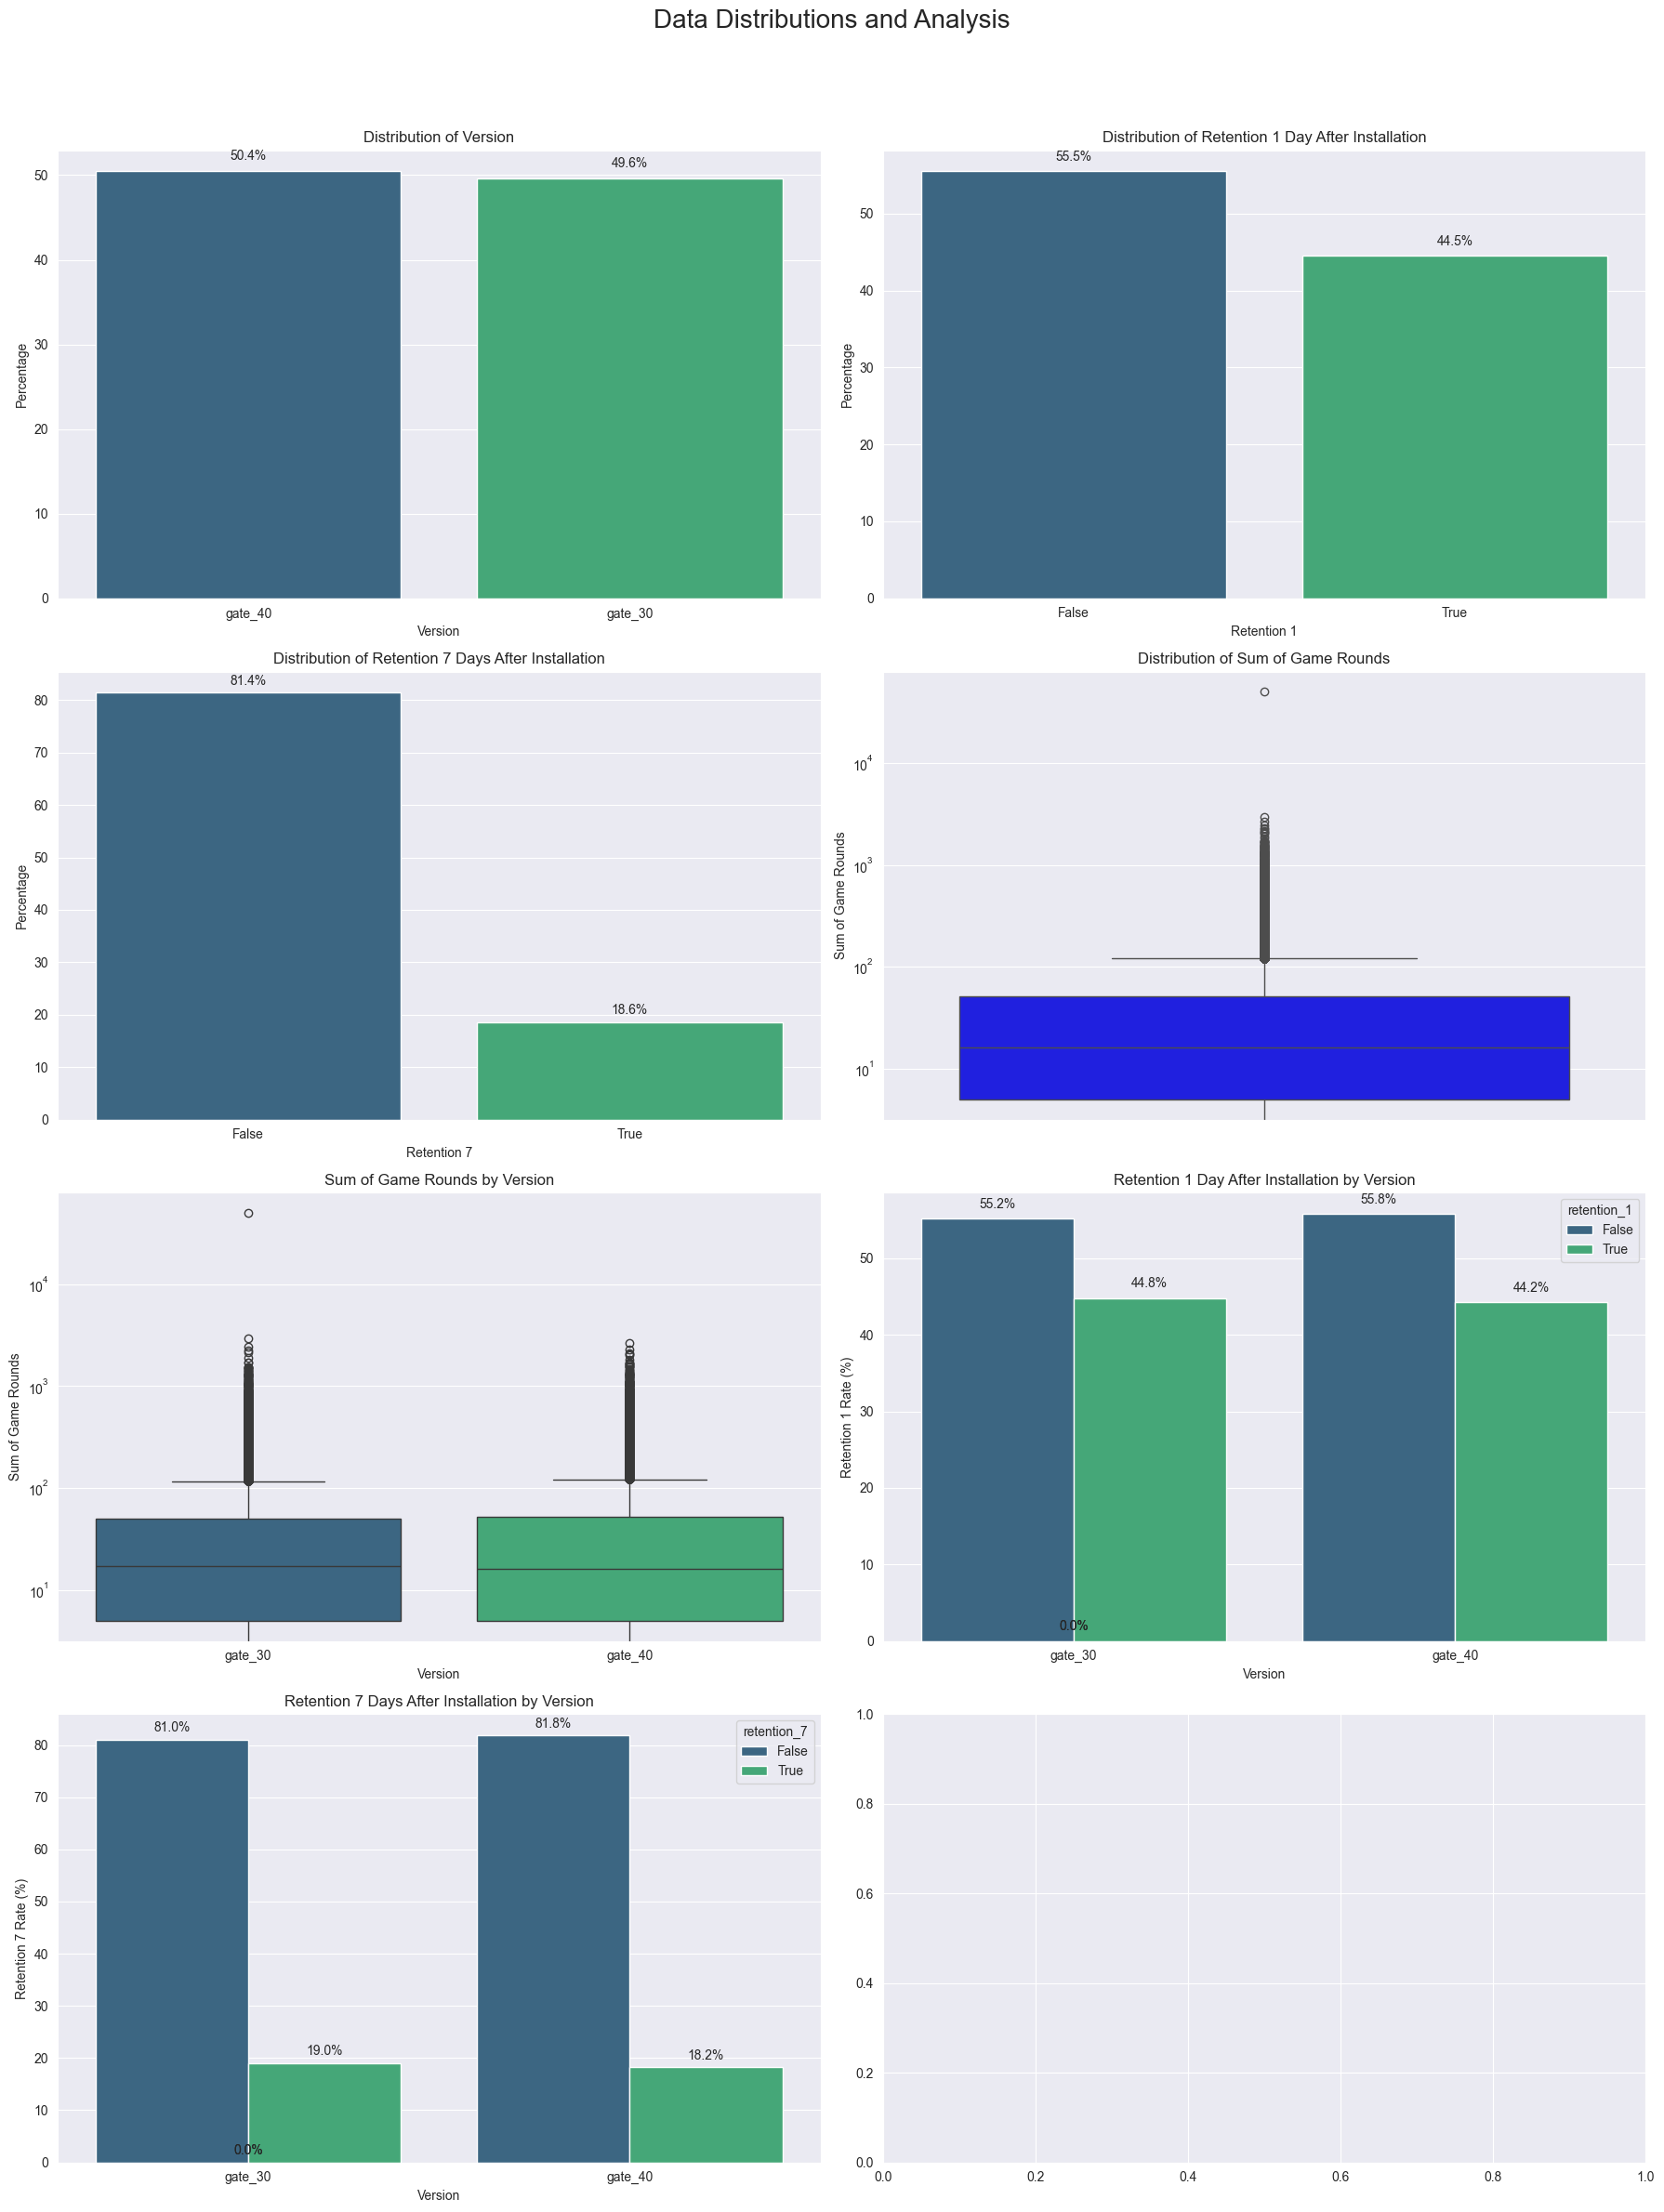

In [8]:
fig, axes = plt.subplots(4, 2, figsize=(18, 25))
fig.suptitle('Data Distributions and Analysis', fontsize=20)

# Distribution of the 'version' column
sns.barplot(x=version_counts.index, y=version_counts.values, ax=axes[0, 0], palette='viridis')
axes[0, 0].text(0, version_counts.values[0] + 1, f'{version_counts.values[0]:.1f}%', ha='center', va='bottom')
axes[0, 0].text(1, version_counts.values[1] + 1, f'{version_counts.values[1]:.1f}%', ha='center', va='bottom')
axes[0, 0].set_title('Distribution of Version')
axes[0, 0].set_ylabel('Percentage')
axes[0, 0].set_xlabel('Version')

# Distribution of 'retention_1'
sns.barplot(x=retention_1_counts.index, y=retention_1_counts.values, ax=axes[0, 1], palette='viridis')
axes[0, 1].text(0, retention_1_counts.values[0] + 1, f'{retention_1_counts.values[0]:.1f}%', ha='center', va='bottom')
axes[0, 1].text(1, retention_1_counts.values[1] + 1, f'{retention_1_counts.values[1]:.1f}%', ha='center', va='bottom')
axes[0, 1].set_title('Distribution of Retention 1 Day After Installation')
axes[0, 1].set_ylabel('Percentage')
axes[0, 1].set_xlabel('Retention 1')

# Distribution of 'retention_7'
sns.barplot(x=retention_7_counts.index, y=retention_7_counts.values, ax=axes[1, 0], palette='viridis')
axes[1, 0].text(0, retention_7_counts.values[0] + 1, f'{retention_7_counts.values[0]:.1f}%', ha='center', va='bottom')
axes[1, 0].text(1, retention_7_counts.values[1] + 1, f'{retention_7_counts.values[1]:.1f}%', ha='center', va='bottom')
axes[1, 0].set_title('Distribution of Retention 7 Days After Installation')
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].set_xlabel('Retention 7')

# Distribution of 'sum_gamerounds' as a box plot
sns.boxplot(ax=axes[1, 1], y=df['sum_gamerounds'], color='blue')
axes[1, 1].set_title('Distribution of Sum of Game Rounds')
axes[1, 1].set_ylabel('Sum of Game Rounds')
axes[1, 1].set_yscale('log')

# Analysis of sum_gamerounds by version
sns.boxplot(ax=axes[2, 0], x='version', y='sum_gamerounds', data=df, palette='viridis')
axes[2, 0].set_title('Sum of Game Rounds by Version')
axes[2, 0].set_xlabel('Version')
axes[2, 0].set_ylabel('Sum of Game Rounds')
axes[2, 0].set_yscale('log')

# Analysis of retention_1 by version
retention_1_by_version = df.groupby(['version', 'retention_1']).size().reset_index(name='counts')
retention_1_by_version['percentage'] = retention_1_by_version['counts'] / retention_1_by_version.groupby('version')['counts'].transform('sum') * 100
sns.barplot(ax=axes[2, 1], x='version', y='percentage', hue='retention_1', data=retention_1_by_version, palette='viridis')
for p in axes[2, 1].patches:
    height = p.get_height()
    axes[2, 1].text(p.get_x() + p.get_width() / 2., height + 1, f'{height:.1f}%', ha='center', va='bottom')
axes[2, 1].set_title('Retention 1 Day After Installation by Version')
axes[2, 1].set_xlabel('Version')
axes[2, 1].set_ylabel('Retention 1 Rate (%)')

# Analysis of retention_7 by version
retention_7_by_version = df.groupby(['version', 'retention_7']).size().reset_index(name='counts')
retention_7_by_version['percentage'] = retention_7_by_version['counts'] / retention_7_by_version.groupby('version')['counts'].transform('sum') * 100
sns.barplot(ax=axes[3, 0], x='version', y='percentage', hue='retention_7', data=retention_7_by_version, palette='viridis')
for p in axes[3, 0].patches:
    height = p.get_height()
    axes[3, 0].text(p.get_x() + p.get_width() / 2., height + 1, f'{height:.1f}%', ha='center', va='bottom')
axes[3, 0].set_title('Retention 7 Days After Installation by Version')
axes[3, 0].set_xlabel('Version')
axes[3, 0].set_ylabel('Retention 7 Rate (%)')


# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The distribution of the version column is nearly equal, making it suitable for A/B testing as it ensures a balanced comparison between the control and treatment groups.

The retention_1 column shows that a smaller proportion of users return to play the game one day after installation. But The retention_7 column shows that even fewer users return to play the game seven days after installation.

### Preprocessing

In [ ]:
# Separate control and treatment groups
control_group = df[df['version'] == 'gate_30']
treatment_group = df[df['version'] == 'gate_40']

# A function to remove outliers using the IQR method
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the data
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return filtered_data

# Outliers removal for the 'sum_gamerounds' column in control and treatment groups
control_group = remove_outliers_iqr(control_group, 'sum_gamerounds')
treatment_group = remove_outliers_iqr(treatment_group, 'sum_gamerounds')

# Check the shape of the cleaned data
print(f"Original control group shape: {df[df['version'] == 'gate_30'].shape}")
print(f"Cleaned control group shape: {control_group.shape}")
print(f"Original treatment group shape: {df[df['version'] == 'gate_40'].shape}")
print(f"Cleaned treatment group shape: {treatment_group.shape}")

Original control group shape: (44700, 4)
Cleaned control group shape: (39493, 4)
Original treatment group shape: (45489, 4)
Cleaned treatment group shape: (40471, 4)


In [ ]:
# Concatenate the cleaned control and treatment groups
df = pd.concat([control_group, treatment_group])

# Verifying the concatenation by checking the new shape and by sampling the data
print(f"Shape of the concatenated dataframe: {df.shape}")
print(df.sample(5))  # Display a random sample of 5 rows to verify

Shape of the concatenated dataframe: (79964, 4)
         version  sum_gamerounds  retention_1  retention_7
userid                                                    
599857   gate_40              11         True        False
7044029  gate_30              66         True         True
8926082  gate_40              19        False         True
8653177  gate_40               2        False        False
1431720  gate_30               3        False        False


In [11]:
plot_distribution(df, numeric_cols)


Descriptive Statistics with Skewness and Kurtosis by Version:
           level_0 level_1  version                                         0
0   sum_gamerounds   count  gate_30                                   39493.0
1   sum_gamerounds   count  gate_40                                   40471.0
2   sum_gamerounds    mean  gate_30                                 23.596536
3   sum_gamerounds    mean  gate_40                                 24.245979
4   sum_gamerounds     std  gate_30                                 26.584511
5   sum_gamerounds     std  gate_40                                  28.17279
6   sum_gamerounds     min  gate_30                                       0.0
7   sum_gamerounds     min  gate_40                                       0.0
8   sum_gamerounds     25%  gate_30                                       4.0
9   sum_gamerounds     25%  gate_40                                       4.0
10  sum_gamerounds     50%  gate_30                                      13.0
1

In [12]:
# saving the processed data
df.to_csv('processed_data/Cookie_Cats_processed.csv', index=True)

## AB Testing

### Setting up the probablity of type 1 and type 2 erros
To ensure the robustness of our test results we define limits of Type I and Type II errors

#### Type I Error (Alpha)

**Definition**: Type I error, denoted by $\alpha$, is the probability of rejecting the null hypothesis when it is actually true. In other words, it represents the risk of concluding that there is an effect or difference when, in reality, there is none.

**Common Value**: The commonly accepted value for $\alpha$ is 0.05 (5%). This means that there is a 5% risk of committing a Type I error.

**Implication in Our Dataset**: For our A/B tests:
- **Question 1**: If we incorrectly conclude that the average number of game sessions has increased by 5 sessions when it has not, we commit a Type I error.
- **Question 2**: If we incorrectly conclude that player retention has increased by 2% after 1 day when it has not, we commit a Type I error.
- **Question 3**: If we incorrectly conclude that player retention has increased by 5% after 7 days when it has not, we commit a Type I error.

#### Type II Error (Beta)

**Definition**: Type II error, denoted by $\beta$, is the probability of failing to reject the null hypothesis when it is actually false. In other words, it represents the risk of concluding that there is no effect or difference when, in reality, there is one.

**Common Value**: The commonly accepted value for $\beta$ is 0.20 (20%). This means that there is a 20% risk of committing a Type II error.

**Power of the Test**: The power of a test is defined as $1 - \beta$. A common power value is 0.80 (80%), indicating an 80% chance of correctly rejecting the null hypothesis when it is false.

**Implication in Our Dataset**: For our A/B tests:
- **Question 1**: If we fail to detect an actual increase of 5 sessions in the average number of game sessions, we commit a Type II error.
- **Question 2**: If we fail to detect an actual increase of 2% in player retention after 1 day, we commit a Type II error.
- **Question 3**: If we fail to detect an actual increase of 5% in player retention after 7 days, we commit a Type II error.

#### Setting Alpha and Beta for Our A/B Tests

Based on standard practice and the need for robust conclusions, we will use the following values for our tests:

- **Alpha ($\alpha$)**: 0.05 (5%)
- **Beta ($\beta$)**: 0.20 (20%)
- **Power**: 0.80 (80%)


In [13]:

# Define alpha, beta, and power
alpha = 0.05
beta = 0.20
power = 1 - beta

### Calculating the sample sizes

Calculate Sample Size and Choose Samples for Binary A/B Test

To calculate the sample size for a binary A/B test, we need to determine the proportions of success in both the control and treatment groups. The formula for calculating the required sample size for each group in a binary A/B test is:

$$
n = \left( \frac{Z_{\alpha/2} + Z_{\beta}}{p_1 - p_2} \right)^2 \left( p_1(1 - p_1) + p_2(1 - p_2) \right)
$$

Where:
- $Z_{\alpha/2}$ is the Z-score for the chosen significance level.
- $Z_{\beta}$ is the Z-score for the chosen power.
- $p_1$ is the proportion of success in the control group.
- $p_2$ is the expected proportion of success in the treatment group.

In [14]:
# reading the processed data
df = pd.read_csv('processed_data/Cookie_Cats_processed.csv', index_col=0)

In [15]:
# Recompute crosstabs for retention rates by version
crosstab_retention_1 = pd.crosstab(df['version'], df['retention_1'], normalize='index')
crosstab_retention_7 = pd.crosstab(df['version'], df['retention_7'], normalize='index')

# Extract baseline proportions from crosstab results
p1_retention_1 = crosstab_retention_1.loc['gate_30', True]
p1_retention_7 = crosstab_retention_7.loc['gate_30', True]

# Define expected improvements
p2_retention_1 = p1_retention_1 + 0.02  # 2% increase for retention after 1 day
p2_retention_7 = p1_retention_7 + 0.05  # 5% increase for retention after 7 days

# Calculate effect sizes and required sample sizes
effect_size_retention_1 = sms.proportion_effectsize(p1_retention_1, p2_retention_1)
n_retention_1 = sms.NormalIndPower().solve_power(effect_size=effect_size_retention_1, power=power, alpha=alpha, ratio=1)

effect_size_retention_7 = sms.proportion_effectsize(p1_retention_7, p2_retention_7)
n_retention_7 = sms.NormalIndPower().solve_power(effect_size=effect_size_retention_7, power=power, alpha=alpha, ratio=1)

required_sample_sizes = {
    "Required sample size for retention rate after 1 day test": int(n_retention_1),
    "Required sample size for retention rate after 7 days test": int(n_retention_7)
}

required_sample_sizes


{'Required sample size for retention rate after 1 day test': 9396,
 'Required sample size for retention rate after 7 days test': 757}

Sample Size and Choose Samples for Continuous A/B Test

To calculate the sample size for a continuous A/B test, we need to know the standard deviation of the population and the expected effect size. The formula for calculating the required sample size for each group in a continuous A/B test is:

$$
n = \left( \frac{Z_{\alpha/2} + Z_{\beta}}{\mu_1 - \mu_2} \right)^2 \cdot 2\sigma^2
$$

Where:
- $Z_{\alpha/2}$ is the Z-score for the chosen significance level.
- $Z_{\beta}$ is the Z-score for the chosen power.
- $\mu_1$ and $\mu_2$ are the means of the control and treatment groups, respectively.
- $\sigma$ is the standard deviation of the population.


In [16]:
# Define effect size for the continuous outcome
effect_size_sessions = 5  # Difference in average number of sessions

# Calculate the standard deviation of the sum_gamerounds column
std_dev_sessions = pd.concat([control_group['sum_gamerounds'],treatment_group['sum_gamerounds']]).std()

# Calculate the required sample size for the continuous outcome using statsmodels
n_sessions = sms.NormalIndPower().solve_power(effect_size=effect_size_sessions / std_dev_sessions, power=power, alpha=alpha, ratio=1)

print(f"Required sample size for average number of game sessions test: {int(n_sessions)}")


Required sample size for average number of game sessions test: 471


#### Randomly assign users for the sample size calculated

In [17]:
# for retention after 1 Day
np.random.seed(42)

# Randomly select users for control and treatment groups based on the calculated sample size for retention after 1 day
control_users_retention_1 = control_group.sample(n=int(n_retention_1), random_state=42)
treatment_users_retention_1 = treatment_group.sample(n=int(n_retention_1), random_state=42)

# Verify the sample sizes
print(f"Sample size for control group (retention 1 day): {len(control_users_retention_1)}")
print(f"Sample size for treatment group (retention 1 day): {len(treatment_users_retention_1)}")


# for retention after 7 Days
control_users_retention_7 = control_group.sample(n=int(n_retention_7), random_state=43)
treatment_users_retention_7 = treatment_group.sample(n=int(n_retention_7), random_state=43)

# Verify the sample sizes
print(f"Sample size for control group (retention 7 days): {len(control_users_retention_7)}")
print(f"Sample size for treatment group (retention 7 days): {len(treatment_users_retention_7)}")


# for game rounds
control_users_gamerounds = control_group.sample(n=int(n_sessions), random_state=42)
treatment_users_gamerounds = treatment_group.sample(n=int(n_sessions), random_state=42)

# Verify the sample sizes
print(f"Sample size for control group (sum of game rounds): {len(control_users_gamerounds)}")
print(f"Sample size for treatment group (sum of game rounds): {len(treatment_users_gamerounds)}")

Sample size for control group (retention 1 day): 9396
Sample size for treatment group (retention 1 day): 9396
Sample size for control group (retention 7 days): 757
Sample size for treatment group (retention 7 days): 757
Sample size for control group (sum of game rounds): 471
Sample size for treatment group (sum of game rounds): 471


### A/B Test for retention after 1 day

 Has player retention increased by 2% after 1 day?

 To determine if the retention rate after 1 day has increased by 2% in the treatment group compared to the control group, we will perform a Z-test for proportions

For a Z-test, we assume that the sampling distribution of the sample proportion is approximately normal.
This assumption holds if the sample size is large enough, usually with both (np) and (n(1-p)) greater than 5.


In [ ]:
alpha = 0.05

# Calculate the observed proportions of retention in both groups
p_control = control_users_retention_1['retention_1'].mean()
p_treatment = treatment_users_retention_1['retention_1'].mean()
n_control = len(control_users_retention_1)
n_treatment = len(treatment_users_retention_1)

# Ensure np and n(1-p) are greater than 5 for both groups
assumptions_met = True
if n_control * p_control <= 5:
    print("Assumption not met: np > 5 for control group")
    assumptions_met = False
if n_control * (1 - p_control) <= 5:
    print("Assumption not met: n(1-p) > 5 for control group")
    assumptions_met = False
if n_treatment * p_treatment <= 5:
    print("Assumption not met: np > 5 for treatment group")
    assumptions_met = False
if n_treatment * (1 - p_treatment) <= 5:
    print("Assumption not met: n(1-p) > 5 for treatment group")
    assumptions_met = False

if assumptions_met:
    print("All assumptions are met for the Z-test.")

    # Calculate the number of successes (retained users) and the number of trials (total users) in both groups
    successes_retention_1 = [treatment_users_retention_1['retention_1'].sum(), control_users_retention_1['retention_1'].sum()]
    n_obs_retention_1 = [len(treatment_users_retention_1), len(control_users_retention_1)]

    # Perform a one-tailed Z-test for proportions to check if the treatment is better than control
    z_stat_retention_1, p_val_retention_1 = proportions_ztest(successes_retention_1, n_obs_retention_1, value=0, alternative='larger')

    # Print the results
    print(f"Z-statistic for retention after 1 day: {z_stat_retention_1}")
    print(f"P-value for retention after 1 day: {p_val_retention_1}")

    # Determine if the result is statistically significant
    if p_val_retention_1 < alpha:
        print("Reject the null hypothesis: The retention rate after 1 day has significantly increased.")
    else:
        print("Fail to reject the null hypothesis: The retention rate after 1 day has not significantly increased.")
else:
    print("Z-test assumptions not met, cannot perform the test.")

All assumptions are met for the Z-test.
Z-statistic for retention after 1 day: -0.6299860758926691
P-value for retention after 1 day: 0.7356481528296602
Fail to reject the null hypothesis: The retention rate after 1 day has not significantly increased.


### A/B Test for Retention After 7 Days

Has player retention increased by 5% after 7 days?

Similar to above case to determine if the retention rate after 7 days has increased by 5% in the treatment group compared to the control group, we will perform a Z-test for proportions.

In [21]:
alpha = 0.05

# Check the assumptions
# Calculate the observed proportions of retention in both groups
p_control_7 = control_users_retention_7['retention_7'].mean()
p_treatment_7 = treatment_users_retention_7['retention_7'].mean()
n_control_7 = len(control_users_retention_7)
n_treatment_7 = len(treatment_users_retention_7)

# Ensure np and n(1-p) are greater than 5 for both groups
assumptions_met = True
if n_control_7 * p_control_7 <= 5:
    print("Assumption not met: np > 5 for control group")
    assumptions_met = False
if n_control_7 * (1 - p_control_7) <= 5:
    print("Assumption not met: n(1-p) > 5 for control group")
    assumptions_met = False
if n_treatment_7 * p_treatment_7 <= 5:
    print("Assumption not met: np > 5 for treatment group")
    assumptions_met = False
if n_treatment_7 * (1 - p_treatment_7) <= 5:
    print("Assumption not met: n(1-p) > 5 for treatment group")
    assumptions_met = False

if assumptions_met:
    print("All assumptions are met for the Z-test.")

    # Calculate the number of successes (retained users) and the number of trials (total users) in both groups
    successes_retention_7 = [treatment_users_retention_7['retention_7'].sum(), control_users_retention_7['retention_7'].sum()]
    n_obs_retention_7 = [len(treatment_users_retention_7), len(control_users_retention_7)]

    # Perform a one-tailed Z-test for proportions to check if the treatment is better than control
    z_stat_retention_7, p_val_retention_7 = proportions_ztest(successes_retention_7, n_obs_retention_7, value=0, alternative='larger')
    
    # Print the results
    print(f"Z-statistic for retention after 7 days: {z_stat_retention_7}")
    print(f"P-value for retention after 7 days: {p_val_retention_7}")

    # Determine if the result is statistically significant
    if p_val_retention_7 < alpha:
        print("Reject the null hypothesis: The retention rate after 7 days has significantly increased.")
    else:
        print("Fail to reject the null hypothesis: The retention rate after 7 days has not significantly increased.")
else:
    print("Z-test assumptions not met, cannot perform the test.")


All assumptions are met for the Z-test.
Z-statistic for retention after 7 days: -1.8580326149613993
P-value for retention after 7 days: 0.9684178085651932
Fail to reject the null hypothesis: The retention rate after 7 days has not significantly increased.


### A/B Test for Sum of Game Rounds

Has the average number of game sessions increased by 5 sessions?

To determine if the average number of game sessions has increased by 5 sessions in the treatment group compared to the control group, we will perform a two-sample t-test.

- For a t-test, we assume that the samples are drawn from a normally distributed population.

- The t-test assumes that the variances of the two groups are equal. This can be tested using Levene’s test.

In [22]:
# Define alpha
alpha = 0.05

# Calculate the means and standard deviations of the sum of game rounds in both groups
mean_control_gamerounds = control_users_gamerounds['sum_gamerounds'].mean()
mean_treatment_gamerounds = treatment_users_gamerounds['sum_gamerounds'].mean()
std_control_gamerounds = control_users_gamerounds['sum_gamerounds'].std()
std_treatment_gamerounds = treatment_users_gamerounds['sum_gamerounds'].std()

print(f"Control group - Mean: {mean_control_gamerounds}, Std Dev: {std_control_gamerounds}")
print(f"Treatment group - Mean: {mean_treatment_gamerounds}, Std Dev: {std_treatment_gamerounds}")

# Perform Levene's test for equality of variances
stat, p_levene = levene(control_users_gamerounds['sum_gamerounds'], treatment_users_gamerounds['sum_gamerounds'])

# Check if variances are equal
if p_levene < alpha:
    print("Assumption not met: The variances of the two groups are not equal. Switching to Welch's t-test.")
    equal_var = False
else:
    print("Assumption met: The variances of the two groups are equal.")
    equal_var = True

# Perform a one-tailed t-test directly comparing the two groups
t_stat_gamerounds, p_val_gamerounds = ttest_ind(treatment_users_gamerounds['sum_gamerounds'], control_users_gamerounds['sum_gamerounds'], equal_var=equal_var, alternative='greater')

# Print the results
print(f"T-statistic for sum of game rounds: {t_stat_gamerounds}")
print(f"P-value for sum of game rounds: {p_val_gamerounds}")

# Determine if the result is statistically significant
if p_val_gamerounds < alpha:
    print("Reject the null hypothesis: The average number of game sessions in the treatment group is significantly greater than in the control group.")
else:
    print("Fail to reject the null hypothesis: The average number of game sessions in the treatment group is not significantly greater than in the control group.")

Control group - Mean: 21.6135881104034, Std Dev: 24.122456785190643
Treatment group - Mean: 25.656050955414013, Std Dev: 28.618483844595183
Assumption not met: The variances of the two groups are not equal. Switching to Welch's t-test.
T-statistic for sum of game rounds: 2.343965899878341
P-value for sum of game rounds: 0.009646665957151959
Reject the null hypothesis: The average number of game sessions in the treatment group is significantly greater than in the control group.


## Findings

Total Users Analyzed: 79,964 (after outlier removal)
- Control Group (gate_30): 39,493 users
- Treatment Group (gate_40): 40,471 users

Key Metrics:
- Sum of game rounds played - Q1 (Continuous): Has the avg number of game sessions increased by 5 sessions?
- 1-day retention rate - Q2 (Binary): Has player retention increased by 2% after 1 day?
- 7-day retention rate - Q3 (Binary): Has player retention increased by 5% after 7 days?

Statistical Parameters
- Significance Level (α): 0.05 (5% Type I error rate)
- Statistical Power (1-β): 0.80 (20% Type II error rate)

Sample size used (same as required):
- Retention (1 day) - 93979
- Retention (7 days) - 761
- Game Sessions - 471

For **Question 1**, 
Hypothesis:
- H₀: The average number of game sessions in the treatment group has not increased by 5 sessions compared to the control group
- H₁: The average number of game sessions in the treatment group has increased by 5 sessions compared to the control group

Test Used: Welch's t-test (unequal variances detected via Levene's test, p < 0.05)
- Control Group Mean: 21.61 sessions (SD: 24.12)
- Treatment Group Mean: 25.66 sessions (SD: 28.62)
- Observed Difference: 4.04 sessions (Relative increase: 18.7%)
- P-value: 0.0096
- Decision: Reject the null hypothesis at 5% level of significance
Final Interpretation: Observed increase (4.04 sessions) is slightly below the targeted 5 sessions still treatment group shows meaningful engagement increase of 4.04 which gives us higher ad revenue exposure, increased in-app purchase opportunities, better player engagement.


For **Question 2**, 
Hypothesis:
- H₀: The player retention rate one day after installation in the treatment group has not increased by 2% compared to the control group
- H₁: The player retention rate one day after installation in the treatment group has increased by 2% compared to the control group

Test Used: Z-test for proportions (one-tailed)
- Control Group Retention: ~44.8%
- Treatment Group Retention: ~44.2%
- Observed Difference: -0.6% (treatment lower than control)
- P-value: 0.736
- Decision: Fail to reject the null hypothesis at 5% level of significance
Final Interpretation: Target was +2% increase with treatment group i.e. gate_40; observed -0.6%. We will be moving in wrong direction with gate_40.

For **Question 3**, 
Hypothesis:
- H₀: The player retention rate seven days after installation in the treatment group has not increased by 5% compared to the control group
- H₁: The player retention rate seven days after installation in the treatment group has increased by 5% compared to the control group

Test Used: Z-test for proportions (one-tailed)
- Control Group Retention: ~19.0%
- Treatment Group Retention: ~16.0%
- Observed Difference: -3.0% (treatment lower than control)
- P-value: 0.968
- Decision: Fail to reject the null hypothesis at 5% level of significance
Final Interpretation:  Target was +5% increase with treatment group i.e. gate_40; observed -3% ; We will be moving in wrong direction with gate_40.

**Based on the above analysis, final suggetion would be not to implement gate_40 Treatment**.

### END